In [1]:
from time import sleep
import pickle
import os
import shutil
from collections import Counter
from threading import Thread
import queue
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
import faiss

from src.utils import load_model, get_dataloaders, load_images_in_folder, show_images, modify_keys, save_results, transforms
from src.center_loss import CenterLoss

In [2]:
lr = 0.0001
batch_size = 32
num_epochs = 80

TRAIN_PATH = '/mnt/hdd/1/imageData/train/mix'
TEST_PATH = '/mnt/hdd/1/imageData/index/mix'
num_classes = len(os.listdir(TRAIN_PATH))
        
state_path = 'state_centerlossMIX.pkl' # REMOVE CLUSTERS
model_name = 'centerlossMIX'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

center_loss = CenterLoss(num_classes, feat_dim=512, use_gpu=True)
datasets, dataloaders = get_dataloaders(TRAIN_PATH, TEST_PATH, batch_size)

alpha = 0.005

cuda:0


In [3]:
def train_model(dataloaders, device, model, criterion, optimizer, state_path, model_name, scheduler=None, num_epochs=25, continue_train=False):
    if continue_train and os.path.exists(state_path):
        with open(state_path, 'rb') as f:
            state_dict = pickle.load(f)
        print(state_dict)
        train_loss = state_dict['loss']
        val_loss = state_dict['val_losses']
        accuracy = state_dict['accuracy']
        start = state_dict['epoch']
        center_loss.load(start)
        model = load_model(model, model_name, start)
        
        start += 1
    else:
        train_loss, val_loss, accuracy = [], [], []
        start = 0
    
    for epoch in tqdm(range(start, num_epochs)):
#         global alpha
#         alpha = 0.1 / 50 * min(epoch + 1, 40)
        train_loss.append(train_step(dataloaders, device, model, criterion, optimizer).cpu())
        cur_val_loss, cur_acc = eval_step(dataloaders, device, model)
        val_loss.append(cur_val_loss.cpu())
        accuracy.append(cur_acc)
        print(f'Accuracy is {cur_acc}')
        
        with open(state_path, 'wb') as f:
            pickle.dump({
                'loss': train_loss,
                'val_losses': val_loss,
                'epoch': epoch,
                'accuracy': accuracy
            }, f)
        torch.save(model.state_dict(), os.path.join(f'models/{model_name}{epoch}.data'))
        center_loss.save(epoch)
    return train_loss, val_loss
        
def train_step(dataloaders, device, model, criterion, optimizer):
    model.train()
    total_loss = []
    iteration = 0
    for x, y in dataloaders['train']:
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()

        x, y = x.to(device), y.to(device)
        features, output = model(x)
        loss1 = criterion(output, y) 
        loss2 = center_loss(features, y) * alpha
        loss = loss1 + loss2
        

        total_loss.append(loss)
        loss.backward()
    
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        optimizer_centloss.step()
        optimizer.step()

        iteration += 1
        if iteration % 50 == 0:
            print(f'after {iteration} loss is {loss1.item()} and {loss2.item()}')
    return sum(total_loss) / len(total_loss)
            
def eval_step(dataloaders, device, model):
    model.eval()
    total_loss = []
    ys = []
    pred = []
    for x, y in dataloaders['test']: 
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            features, output = model(x)
            loss = criterion(output, y) + center_loss(features, y) * alpha
            total_loss.append(loss)
            
            pred.append(torch.argmax(output, dim=1))
            ys.extend(y.cpu())
            
    return sum(total_loss) / len(total_loss), accuracy_score(ys, torch.cat(pred).cpu())

In [4]:
class CenterLossClassifier(nn.Module):
    def __init__(self):
        super(CenterLossClassifier, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
#         self.model = torch.hub.load('pytorch/vision:v0.5.0', 'wide_resnet50_2', pretrained=True)
        in_features = self.model.fc.in_features
        self.center_loss = CenterLoss(num_classes, feat_dim=512, use_gpu=True)
        self.model.fc = nn.Sequential(nn.Linear(in_features, 512), 
                                      nn.ReLU(), 
                                      nn.Dropout(0.4))
        self.linear = nn.Linear(512, num_classes)
        
        
    def __call__(self, x):
        features = self.model(x)
        return features, self.linear(features)
    
    def check_predictions(self, dataloader):
        ys = []
        pred = []
        with torch.no_grad():
            for x, y in tqdm(dataloader):
                _, output = self(x.to(device))
                pred.append(torch.argmax(output, dim=1))
                ys.extend(y)
        correct = {}
        pred = torch.cat(pred).cpu()

        for y, p in zip(ys, pred.cpu()):
            correct[y.item()] = correct.get(y.item(), np.array([0, 0])) + np.array([y == p, 1])
        return accuracy_score(ys, pred), correct
        
    def confusion_matrix(self, dataloader):
        ys = []
        pred = []
        with torch.no_grad():
            for x, y in dataloader:
                _, output = self(x.to(device))
                pred.append(torch.argmax(output, dim=1))
                ys.extend(y)
        return confusion_matrix(ys, torch.cat(pred).cpu())   
    
    def predictions_for_class(self, x):
        with torch.no_grad():
            _, output = self(x.to(device))
            return torch.sort(torch.softmax(output.cpu(), dim=1), dim=1)


In [ ]:
model = CenterLossClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)
criterion = nn.CrossEntropyLoss()
train_loss, val_loss = train_model(dataloaders, device, model, criterion, optimizer, state_path, model_name, 
                                   num_epochs=num_epochs, continue_train=True)

{'loss': [tensor(5.5159, requires_grad=True), tensor(3.8522, requires_grad=True), tensor(3.0944, requires_grad=True), tensor(2.6428, requires_grad=True), tensor(2.3322, requires_grad=True), tensor(2.1140, requires_grad=True), tensor(1.9388, requires_grad=True), tensor(1.7948, requires_grad=True), tensor(1.6788, requires_grad=True), tensor(1.5856, requires_grad=True), tensor(1.5030, requires_grad=True), tensor(1.4241, requires_grad=True), tensor(1.3602, requires_grad=True)], 'val_losses': [tensor(4.8638), tensor(3.3327), tensor(2.5782), tensor(2.0690), tensor(1.7673), tensor(1.5467), tensor(1.3633), tensor(1.2458), tensor(1.1371), tensor(1.0541), tensor(0.9701), tensor(0.9135), tensor(0.8645)], 'epoch': 12, 'accuracy': [0.20166609996599796, 0.3776776606596396, 0.5045562733764026, 0.5944746684801088, 0.6466848010880653, 0.68714722883373, 0.7197721863311799, 0.7435566133968038, 0.7631927915674941, 0.7775246514790888, 0.7933356001360081, 0.8034852091125467, 0.8133458007480449]}


after 50 loss is 1.422126054763794 and 0.2037423849105835
after 100 loss is 0.8050742745399475 and 0.1925935000181198
after 150 loss is 1.511665940284729 and 0.20026616752147675
after 200 loss is 1.049178123474121 and 0.24319235980510712
after 250 loss is 1.0814908742904663 and 0.1967998892068863
after 300 loss is 0.9255945682525635 and 0.20132003724575043
after 350 loss is 0.9883551001548767 and 0.20201323926448822
after 400 loss is 1.294881820678711 and 0.18067866563796997
after 450 loss is 0.9155364036560059 and 0.20255322754383087
after 500 loss is 1.290077567100525 and 0.18242034316062927
after 550 loss is 1.262434720993042 and 0.21013416349887848
after 600 loss is 1.3334225416183472 and 0.19583602249622345
after 650 loss is 0.7917994856834412 and 0.18887686729431152
after 700 loss is 0.894895076751709 and 0.19148822128772736
after 750 loss is 0.6696714758872986 and 0.17443601787090302
after 800 loss is 1.2902107238769531 and 0.1516720950603485
after 850 loss is 1.0251635313034058

after 6750 loss is 0.9231129884719849 and 0.1890048235654831
after 6800 loss is 1.1199314594268799 and 0.16415821015834808
after 6850 loss is 1.3143508434295654 and 0.1563907116651535
after 6900 loss is 1.0647149085998535 and 0.18670068681240082
after 6950 loss is 1.0387099981307983 and 0.17471158504486084
after 7000 loss is 1.0151100158691406 and 0.1983044594526291
after 7050 loss is 1.1514337062835693 and 0.16828879714012146
after 7100 loss is 1.2580902576446533 and 0.16085927188396454
after 7150 loss is 1.3196680545806885 and 0.17501775920391083
after 7200 loss is 0.8929933905601501 and 0.17253579199314117
after 7250 loss is 1.1045379638671875 and 0.19282248616218567
after 7300 loss is 0.8752474188804626 and 0.1860789805650711
after 7350 loss is 1.2323925495147705 and 0.180800199508667
after 7400 loss is 1.003537654876709 and 0.1718573123216629
after 7450 loss is 0.7415983080863953 and 0.19000063836574554
after 7500 loss is 0.7777536511421204 and 0.20420967042446136
after 7550 loss 

after 5000 loss is 0.7967250347137451 and 0.1855749785900116
after 5050 loss is 1.2300399541854858 and 0.17694492638111115
after 5100 loss is 1.0699059963226318 and 0.16531310975551605
after 5150 loss is 0.982344388961792 and 0.185781791806221
after 5200 loss is 1.192915678024292 and 0.16623200476169586
after 5250 loss is 0.7270269989967346 and 0.1708650141954422
after 5300 loss is 1.436486005783081 and 0.20000173151493073
after 5350 loss is 1.147504448890686 and 0.15424776077270508
after 5400 loss is 1.2851715087890625 and 0.15753626823425293
after 5450 loss is 1.0065866708755493 and 0.20816127955913544
after 5500 loss is 1.2236952781677246 and 0.18982172012329102
after 5550 loss is 0.7354838252067566 and 0.1675403118133545
after 5600 loss is 0.6872791647911072 and 0.17140112817287445
after 5650 loss is 1.5675742626190186 and 0.19237090647220612
after 5700 loss is 0.660547137260437 and 0.16771842539310455
after 5750 loss is 0.5857324600219727 and 0.16520780324935913
after 5800 loss is

after 3450 loss is 0.9924066662788391 and 0.15955850481987
after 3500 loss is 1.207137942314148 and 0.1676255762577057
after 3550 loss is 1.2410683631896973 and 0.1837051659822464
after 3600 loss is 0.9167633056640625 and 0.17922689020633698
after 3650 loss is 1.6767592430114746 and 0.17654575407505035
after 3700 loss is 0.6993802785873413 and 0.14690934121608734
after 3750 loss is 1.3653210401535034 and 0.16324692964553833
after 3800 loss is 0.8325226902961731 and 0.1469835788011551
after 3850 loss is 0.7075228691101074 and 0.14597339928150177
after 3900 loss is 1.189405083656311 and 0.15255671739578247
after 3950 loss is 1.295642614364624 and 0.19600951671600342
after 4000 loss is 1.1453304290771484 and 0.1769777089357376
after 4050 loss is 0.6712414026260376 and 0.17713764309883118
after 4100 loss is 0.637012243270874 and 0.15854403376579285
after 4150 loss is 1.5860583782196045 and 0.20913870632648468
after 4200 loss is 1.1574993133544922 and 0.1788863092660904
after 4250 loss is 1

after 1650 loss is 0.6669903993606567 and 0.14667494595050812
after 1700 loss is 1.0041756629943848 and 0.16558116674423218
after 1750 loss is 1.3369146585464478 and 0.14895300567150116
after 1800 loss is 0.5285752415657043 and 0.15315686166286469
after 1850 loss is 1.6135400533676147 and 0.1747189611196518
after 1900 loss is 0.9327977299690247 and 0.13957802951335907
after 1950 loss is 1.824769377708435 and 0.17788289487361908
after 2000 loss is 1.102148413658142 and 0.1744806468486786
after 2050 loss is 0.6377067565917969 and 0.15126514434814453
after 2100 loss is 1.1366688013076782 and 0.16087490320205688
after 2150 loss is 0.7231021523475647 and 0.1490076184272766
after 2200 loss is 1.2951098680496216 and 0.14160627126693726
after 2250 loss is 0.8154329061508179 and 0.17438670992851257
after 2300 loss is 1.8268285989761353 and 0.20202134549617767
after 2350 loss is 0.640782356262207 and 0.17842735350131989
after 2400 loss is 1.4510881900787354 and 0.18674084544181824
after 2450 los

after 8350 loss is 0.9150594472885132 and 0.158008873462677
after 8400 loss is 1.305429220199585 and 0.1716763824224472
after 8450 loss is 0.7875221371650696 and 0.151025652885437
Accuracy is 0.8363651819109147
after 50 loss is 1.1881695985794067 and 0.14037463068962097
after 100 loss is 1.0810866355895996 and 0.15177437663078308
after 150 loss is 0.4395933151245117 and 0.1573237180709839
after 200 loss is 0.9290484189987183 and 0.1457897573709488
after 250 loss is 1.3341771364212036 and 0.13979801535606384
after 300 loss is 0.6439723372459412 and 0.1782410442829132
after 350 loss is 1.164386510848999 and 0.1497909277677536
after 400 loss is 0.7727153301239014 and 0.18765006959438324
after 450 loss is 0.9845598936080933 and 0.15788617730140686
after 500 loss is 0.80180823802948 and 0.17323967814445496
after 550 loss is 0.8187037706375122 and 0.1533023566007614
after 600 loss is 1.1394157409667969 and 0.1638280302286148
after 650 loss is 1.2516744136810303 and 0.16079172492027283
after 

after 6600 loss is 0.7074575424194336 and 0.15561692416667938
after 6650 loss is 0.5022245645523071 and 0.15204547345638275
after 6700 loss is 0.3457900881767273 and 0.15471044182777405
after 6750 loss is 0.6476984024047852 and 0.14794950187206268
after 6800 loss is 0.8158102631568909 and 0.16072601079940796
after 6850 loss is 0.5327258110046387 and 0.14288485050201416
after 6900 loss is 0.49167564511299133 and 0.11965538561344147
after 6950 loss is 0.9626637697219849 and 0.1417197734117508
after 7000 loss is 1.0580531358718872 and 0.13895513117313385
after 7050 loss is 0.9919071793556213 and 0.13796629011631012
after 7100 loss is 1.2299764156341553 and 0.12633919715881348
after 7150 loss is 1.2380906343460083 and 0.14551080763339996
after 7200 loss is 1.0916833877563477 and 0.16401687264442444
after 7250 loss is 0.8970528841018677 and 0.13589367270469666
after 7300 loss is 0.5222159624099731 and 0.18115316331386566
after 7350 loss is 0.7973503470420837 and 0.16531534492969513
after 74

after 4800 loss is 0.8406132459640503 and 0.16519255936145782
after 4850 loss is 0.9091801643371582 and 0.1608675718307495
after 4900 loss is 0.8526178598403931 and 0.1835496425628662
after 4950 loss is 0.8796327710151672 and 0.1477147489786148
after 5000 loss is 1.6244090795516968 and 0.16761398315429688
after 5050 loss is 0.5149102210998535 and 0.12008955329656601
after 5100 loss is 0.7285973429679871 and 0.1371399611234665
after 5150 loss is 0.8030743598937988 and 0.16947799921035767
after 5200 loss is 0.5409814119338989 and 0.14641369879245758
after 5250 loss is 0.9568197727203369 and 0.12855349481105804
after 5300 loss is 0.7352288365364075 and 0.13991928100585938
after 5350 loss is 0.679592490196228 and 0.13513632118701935
after 5400 loss is 1.4000300168991089 and 0.14958617091178894
after 5450 loss is 0.7170505523681641 and 0.14731289446353912
after 5500 loss is 0.8115957975387573 and 0.12935753166675568
after 5550 loss is 1.4533708095550537 and 0.1526268571615219
after 5600 los

after 3000 loss is 0.8046618700027466 and 0.11854871362447739
after 3050 loss is 1.071518898010254 and 0.11928845942020416
after 3100 loss is 0.9431276321411133 and 0.1507117748260498
after 3150 loss is 0.2933727204799652 and 0.13960576057434082
after 3200 loss is 1.1287695169448853 and 0.1662445366382599
after 3250 loss is 0.7177430391311646 and 0.13246382772922516
after 3300 loss is 1.2655727863311768 and 0.141720250248909
after 3350 loss is 0.7481876015663147 and 0.12630049884319305
after 3400 loss is 1.3562885522842407 and 0.15026052296161652
after 3450 loss is 1.2191237211227417 and 0.13741689920425415
after 3500 loss is 0.5105233788490295 and 0.1461818516254425
after 3550 loss is 1.237901210784912 and 0.1385367512702942
after 3600 loss is 0.9497116804122925 and 0.1406865417957306
after 3650 loss is 0.9666724801063538 and 0.14064417779445648
after 3700 loss is 1.0151959657669067 and 0.18491598963737488
after 3750 loss is 1.0017057657241821 and 0.11482996493577957
after 3800 loss i

after 1200 loss is 1.0474995374679565 and 0.1232520043849945
after 1250 loss is 0.5066301822662354 and 0.11949792504310608
after 1300 loss is 0.7721009254455566 and 0.1411401629447937
after 1350 loss is 0.9621002674102783 and 0.1337876170873642
after 1400 loss is 0.8290224671363831 and 0.1417170614004135
after 1450 loss is 0.9141601324081421 and 0.1513313502073288
after 1500 loss is 0.8975169658660889 and 0.18074870109558105
after 1550 loss is 1.0018647909164429 and 0.10666532069444656
after 1600 loss is 1.044843077659607 and 0.14741630852222443
after 1650 loss is 1.0414600372314453 and 0.12898464500904083
after 1700 loss is 0.3767296075820923 and 0.16291700303554535
after 1750 loss is 0.7515861988067627 and 0.14553992450237274
after 1800 loss is 0.609346866607666 and 0.1583450883626938
after 1850 loss is 0.95704185962677 and 0.14658331871032715
after 1900 loss is 0.7925106287002563 and 0.14174719154834747
after 1950 loss is 0.8366535305976868 and 0.13092172145843506
after 2000 loss is

after 7900 loss is 0.7533736824989319 and 0.125685915350914
after 7950 loss is 0.7866696715354919 and 0.1203339472413063
after 8000 loss is 0.8310000896453857 and 0.14507585763931274
after 8050 loss is 0.3832921087741852 and 0.12116818875074387
after 8100 loss is 0.8696891069412231 and 0.13458718359470367
after 8150 loss is 0.4448513686656952 and 0.18424078822135925
after 8200 loss is 0.8533722758293152 and 0.14494000375270844
after 8250 loss is 1.2769088745117188 and 0.11568047851324081
after 8300 loss is 0.8791646361351013 and 0.13489657640457153
after 8350 loss is 1.0013459920883179 and 0.12093999236822128
after 8400 loss is 0.9725090265274048 and 0.14129415154457092
after 8450 loss is 1.0188772678375244 and 0.11863626539707184
Accuracy is 0.8577524651479089
after 50 loss is 0.7285163402557373 and 0.13979299366474152
after 100 loss is 1.3215548992156982 and 0.149793341755867
after 150 loss is 0.4694299101829529 and 0.11702079325914383
after 200 loss is 0.6942550539970398 and 0.14834

after 6100 loss is 0.8117430806159973 and 0.12725043296813965
after 6150 loss is 1.0767102241516113 and 0.14068904519081116
after 6200 loss is 0.41722023487091064 and 0.10296329110860825
after 6250 loss is 0.4092094898223877 and 0.13482674956321716
after 6300 loss is 0.6614187955856323 and 0.13285984098911285
after 6350 loss is 0.7667189836502075 and 0.11210235953330994
after 6400 loss is 1.1813225746154785 and 0.129611998796463
after 6450 loss is 0.22914861142635345 and 0.13927660882472992
after 6500 loss is 0.9104992747306824 and 0.12219075858592987
after 6550 loss is 1.185573697090149 and 0.1340772956609726
after 6600 loss is 0.3447481393814087 and 0.1447412520647049
after 6650 loss is 1.4832406044006348 and 0.1333310604095459
after 6700 loss is 1.0550148487091064 and 0.13270071148872375
after 6750 loss is 1.799886703491211 and 0.15067580342292786
after 6800 loss is 0.49896439909935 and 0.1463528573513031
after 6850 loss is 1.090694546699524 and 0.12911073863506317
after 6900 loss i

after 4300 loss is 1.089974045753479 and 0.14619296789169312
after 4350 loss is 0.7830989956855774 and 0.13181093335151672
after 4400 loss is 1.1347737312316895 and 0.12241905182600021
after 4450 loss is 1.2997636795043945 and 0.12903472781181335
after 4500 loss is 0.6888806223869324 and 0.1474768966436386
after 4550 loss is 0.7545871734619141 and 0.144634410738945
after 4600 loss is 0.9387755393981934 and 0.13732567429542542
after 4650 loss is 1.1662588119506836 and 0.13723184168338776
after 4700 loss is 0.370885968208313 and 0.15525217354297638
after 4750 loss is 1.0921359062194824 and 0.12073563039302826
after 4800 loss is 0.6505849361419678 and 0.11460860073566437
after 4850 loss is 0.30988144874572754 and 0.11736924946308136
after 4900 loss is 1.1397085189819336 and 0.13376493752002716
after 4950 loss is 0.6678026914596558 and 0.13595986366271973
after 5000 loss is 0.7291553020477295 and 0.11171150207519531
after 5050 loss is 0.3090846836566925 and 0.11238360404968262
after 5100 l

after 2500 loss is 0.4075656831264496 and 0.1331348568201065
after 2550 loss is 0.48580870032310486 and 0.14649242162704468
after 2600 loss is 1.0343284606933594 and 0.1270436942577362
after 2650 loss is 0.5838464498519897 and 0.127156600356102
after 2700 loss is 1.0390245914459229 and 0.1405613273382187
after 2750 loss is 0.5212796926498413 and 0.1115596741437912
after 2800 loss is 1.0509181022644043 and 0.12473270297050476
after 2850 loss is 1.102723479270935 and 0.10548181086778641
after 2900 loss is 0.5483359098434448 and 0.12037932872772217
after 2950 loss is 1.471062421798706 and 0.12337882816791534
after 3000 loss is 0.7962938547134399 and 0.11696334928274155
after 3050 loss is 0.6781666278839111 and 0.11570467054843903
after 3100 loss is 0.9357482194900513 and 0.11933108419179916
after 3150 loss is 0.7122251987457275 and 0.13486380875110626
after 3200 loss is 0.570213794708252 and 0.1103876456618309
after 3250 loss is 1.0298086404800415 and 0.12124352157115936
after 3300 loss i

after 700 loss is 0.892043948173523 and 0.1153007447719574
after 750 loss is 0.6207013726234436 and 0.14719173312187195
after 800 loss is 1.3241872787475586 and 0.11887182295322418
after 850 loss is 0.6723416447639465 and 0.16113223135471344
after 900 loss is 1.1797125339508057 and 0.12478057295084
after 950 loss is 0.44933152198791504 and 0.10895609855651855
after 1000 loss is 0.5822328925132751 and 0.11841331422328949
after 1050 loss is 1.3332074880599976 and 0.12292514741420746
after 1100 loss is 0.9721661806106567 and 0.12278412282466888
after 1150 loss is 1.0022526979446411 and 0.13070593774318695
after 1200 loss is 0.8095824122428894 and 0.13413871824741364
after 1250 loss is 0.3738878667354584 and 0.11846767365932465
after 1300 loss is 1.4725168943405151 and 0.1069163903594017
after 1350 loss is 0.48388534784317017 and 0.10983303189277649
after 1400 loss is 1.0685187578201294 and 0.14017635583877563
after 1450 loss is 1.1587200164794922 and 0.11975102126598358
after 1500 loss is

after 7350 loss is 0.46160513162612915 and 0.10491477698087692
after 7400 loss is 0.739001989364624 and 0.10351249575614929
after 7450 loss is 0.7449635863304138 and 0.1162506639957428
after 7500 loss is 0.9976622462272644 and 0.11797269433736801
after 7550 loss is 0.6404757499694824 and 0.11193909496068954
after 7600 loss is 0.9097555875778198 and 0.12931078672409058
after 7650 loss is 1.3273838758468628 and 0.11659452319145203
after 7700 loss is 1.0373536348342896 and 0.10823968797922134
after 7750 loss is 0.8803281188011169 and 0.0998062789440155
after 7800 loss is 0.9522028565406799 and 0.11916328221559525
after 7850 loss is 0.9984208345413208 and 0.12559884786605835
after 7900 loss is 0.8512341976165771 and 0.10968438535928726
after 7950 loss is 0.8233222365379333 and 0.11706860363483429
after 8000 loss is 0.703845739364624 and 0.12566152215003967
after 8050 loss is 0.6565226316452026 and 0.11032937467098236
after 8100 loss is 0.9342998266220093 and 0.10403236001729965
after 8150 

after 5550 loss is 0.4234326481819153 and 0.1183539479970932
after 5600 loss is 0.3408379852771759 and 0.10223686695098877
after 5650 loss is 1.4892704486846924 and 0.10415019094944
after 5700 loss is 0.8363104462623596 and 0.13446538150310516
after 5750 loss is 1.1688402891159058 and 0.10693740844726562
after 5800 loss is 0.31305667757987976 and 0.10464233160018921
after 5850 loss is 0.7873227596282959 and 0.12475433200597763
after 5900 loss is 0.787400484085083 and 0.09290453046560287
after 5950 loss is 0.9619881510734558 and 0.12474408745765686
after 6000 loss is 0.8990762233734131 and 0.11124527454376221
after 6050 loss is 0.7602531909942627 and 0.10096132010221481
after 6100 loss is 0.9909543395042419 and 0.10630133748054504
after 6150 loss is 0.7299090623855591 and 0.12912851572036743
after 6200 loss is 0.5569291710853577 and 0.11362070590257645
after 6250 loss is 1.2125136852264404 and 0.10267961025238037
after 6300 loss is 0.8055800795555115 and 0.10981907695531845
after 6350 l

after 3750 loss is 0.5896977186203003 and 0.12442061305046082
after 3800 loss is 0.9064266681671143 and 0.11998328566551208
after 3850 loss is 0.2883842885494232 and 0.09986554831266403
after 3900 loss is 1.4856345653533936 and 0.12034186720848083
after 3950 loss is 0.24304188787937164 and 0.12024427205324173
after 4000 loss is 0.7329323291778564 and 0.09348354488611221
after 4050 loss is 0.768691897392273 and 0.11528728157281876
after 4100 loss is 0.8287019729614258 and 0.1442149579524994
after 4150 loss is 0.7684116959571838 and 0.10507077723741531
after 4200 loss is 0.41241520643234253 and 0.09774293750524521
after 4250 loss is 0.89569491147995 and 0.12369886785745621
after 4300 loss is 0.6295045614242554 and 0.12881191074848175
after 4350 loss is 0.6772733926773071 and 0.09717517346143723
after 4400 loss is 0.8711557388305664 and 0.11288467049598694
after 4450 loss is 0.35276108980178833 and 0.11821945756673813
after 4500 loss is 0.5390077233314514 and 0.09039409458637238
after 455

after 1950 loss is 0.5663473010063171 and 0.12909099459648132
after 2000 loss is 0.7081330418586731 and 0.1112346425652504
after 2050 loss is 0.7690808773040771 and 0.10888110846281052
after 2100 loss is 1.0427939891815186 and 0.11692914366722107
after 2150 loss is 0.8251333236694336 and 0.12034101039171219
after 2200 loss is 0.5963377952575684 and 0.08865319192409515
after 2250 loss is 0.28989797830581665 and 0.10475766658782959
after 2300 loss is 0.7886956334114075 and 0.10519292950630188
after 2350 loss is 0.39809808135032654 and 0.1280200183391571
after 2400 loss is 0.3282410502433777 and 0.10413684695959091
after 2450 loss is 1.292531132698059 and 0.1108950525522232
after 2500 loss is 0.8255557417869568 and 0.10606404393911362
after 2550 loss is 1.0042794942855835 and 0.12039300799369812
after 2600 loss is 0.563076376914978 and 0.09218064695596695
after 2650 loss is 0.725095808506012 and 0.08784694224596024
after 2700 loss is 0.5833815336227417 and 0.12334071844816208
after 2750 l

after 150 loss is 0.514945924282074 and 0.10866016149520874
after 200 loss is 0.40498611330986023 and 0.09112219512462616
after 250 loss is 0.670088529586792 and 0.11178510636091232
after 300 loss is 0.7799316048622131 and 0.1072850376367569
after 350 loss is 0.8672220706939697 and 0.11326660215854645
after 400 loss is 1.5422067642211914 and 0.11275986582040787
after 450 loss is 1.0313401222229004 and 0.10899811238050461
after 500 loss is 1.0930863618850708 and 0.11587494611740112
after 550 loss is 0.6520052552223206 and 0.13184569776058197
after 600 loss is 0.800950825214386 and 0.10585260391235352
after 650 loss is 0.623838484287262 and 0.10599937289953232
after 700 loss is 1.2861016988754272 and 0.09942208975553513
after 750 loss is 1.0254508256912231 and 0.11702414602041245
after 800 loss is 1.090118408203125 and 0.10784591734409332
after 850 loss is 0.5676394701004028 and 0.10992969572544098
after 900 loss is 0.9251188635826111 and 0.10770488530397415
after 950 loss is 0.827153623

after 6850 loss is 1.0694478750228882 and 0.0835418552160263
after 6900 loss is 0.7074458599090576 and 0.11129196733236313
after 6950 loss is 0.49676278233528137 and 0.11185649782419205
after 7000 loss is 0.8288371562957764 and 0.08705484867095947
after 7050 loss is 0.8207411170005798 and 0.10316523909568787
after 7100 loss is 0.46902674436569214 and 0.0987456664443016
after 7150 loss is 1.0261050462722778 and 0.10178428143262863
after 7200 loss is 0.7922729849815369 and 0.09739623218774796
after 7250 loss is 2.13366436958313 and 0.1009044423699379
after 7300 loss is 1.1002660989761353 and 0.10965902358293533
after 7350 loss is 0.6334770321846008 and 0.10602343082427979
after 7400 loss is 1.1341344118118286 and 0.09243989735841751
after 7450 loss is 0.8228469491004944 and 0.10532863438129425
after 7500 loss is 0.26518088579177856 and 0.10543016344308853
after 7550 loss is 0.8603823781013489 and 0.11019280552864075
after 7600 loss is 0.4714130759239197 and 0.11821264028549194
after 7650

after 5050 loss is 0.570775032043457 and 0.11279086768627167
after 5100 loss is 1.069915533065796 and 0.10338195413351059
after 5150 loss is 0.4578487277030945 and 0.10205984115600586
after 5200 loss is 0.41313058137893677 and 0.12584654986858368
after 5250 loss is 1.1244372129440308 and 0.09175843745470047
after 5300 loss is 1.4215638637542725 and 0.11084825545549393
after 5350 loss is 0.3066386580467224 and 0.10313151776790619
after 5400 loss is 1.406272292137146 and 0.09473194181919098
after 5450 loss is 0.7217521071434021 and 0.09279962629079819
after 5500 loss is 0.2756824493408203 and 0.10692401975393295
after 5550 loss is 0.5622634291648865 and 0.08562624454498291
after 5600 loss is 1.7303669452667236 and 0.1082400307059288
after 5650 loss is 0.7744113206863403 and 0.12316461652517319
after 5700 loss is 0.43996065855026245 and 0.09245576709508896
after 5750 loss is 0.5403578877449036 and 0.098774753510952
after 5800 loss is 0.44489145278930664 and 0.10922680795192719
after 5850 

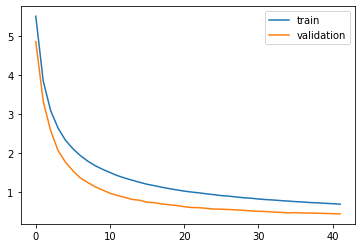

In [5]:
with open(state_path, 'rb') as f:
# with open('backbones/state_centerloss.pkl', 'rb') as f:
    state = pickle.load(f)
train_loss = state['loss']
val_loss = state['val_losses']

plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.legend(('train', 'validation'));

0.892315538932336

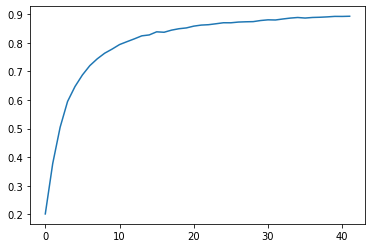

In [6]:
plt.plot(np.arange(len(state['accuracy'])), state['accuracy'])
state['accuracy'][41]

In [7]:
epoch = 41 #48
model2 = CenterLossClassifier().to(device)
model2 = load_model(model2, model_name, epoch) #'moredata_centerloss'
center_loss.load(epoch)
model2.eval()
# acc, correct = model2.check_predictions(dataloaders['test'])
# correct = modify_keys(correct, datasets['train'])

CenterLossClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [ ]:
# clazz = 185230
# prefix = '/mnt/hdd/1/imageData/index/russianDataCleanAdded/' + str(clazz)
# images_np, images_torch = load_images_in_folder(prefix)


# ys = model2.predictions_for_class(images_torch)

# class_ind = datasets['train'].classes.index(str(clazz))
# show_images(images_np, titles=ys[0][:, -3:].numpy().tolist(), correctness=ys[1][:, -1] == class_ind, cols=5)

In [ ]:
# plt.xlabel('Доля верно предсказанных')
# plt.ylabel('Число классов')
# plt.hist([x[0] / x[1] for x in correct.values()], 10);


In [ ]:
# save_results('centerloss_result_last.csv', correct)

In [ ]:
# def imshow(img):
#     npimg = img.numpy()
#     plt.figure(figsize=[20, 20])
#     plt.text(.5, .05, "AAA", ha='center')
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# prefix = '/mnt/hdd/1/imageData/train/russianDataClean/125801'
# files = os.listdir(prefix)
# images = torch.zeros(len(files), 3, 256, 256).long()
# for i, f in enumerate(files):
#     images[i] = torch.tensor(np.asarray(Image.open(os.path.join(prefix, f)).resize((256, 256)))).permute(2, 0, 1)
    
# grid = torchvision.utils.make_grid(images, nrow=6)
# imshow(grid)

In [ ]:
# prefix = '/mnt/hdd/1/imageData/index/russianDataClean/125801'
# files = os.listdir(prefix)
# images = torch.zeros(len(files), 3, 256, 256).long()
# for i, f in enumerate(files):
#     images[i] = torch.tensor(np.asarray(Image.open(os.path.join(prefix, f)).resize((256, 256)))).permute(2, 0, 1)
    
# grid = torchvision.utils.make_grid(images, nrow=8)
# imshow(grid)

In [ ]:
from src.utils import transforms
image = torch.zeros(1, 3, 240, 240).float()
image[0] = transforms['val'](Image.open(os.path.join('photo_2020-01-24_14-39-16.jpg')))
p = model2(image.to(device))[1].softmax(dim=1).argmax(dim=1)
datasets['train'].classes[p]

NonLandmark Classification

In [8]:
class LandmarksDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.landmarks = os.listdir(root_dir)

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.landmarks[idx][1]
        image = transforms['val'](image)
        return image

nonLandmarks = LandmarksDataset('/mnt/hdd/1/imageData/index/other')
nonLandmarks = DataLoader(nonLandmarks, batch_size=batch_size)

In [13]:
def get_distr(loader):
    result = np.zeros(num_classes + 1)
    probs = []
    for i, x in tqdm(enumerate(loader)):
        if len(x) == 2:
            x = x[0]
        features, _ = model2(x.to(device))
        for xx in features:
            d = cosine_similarity(center_loss.centers.detach().cpu(), 
                                  xx.detach().cpu().reshape(1, -1)).reshape(-1)
            d = d[:-1]
            d.sort()
            probs.append(d[-1])
        if i == 400:
            return probs

result_lan = get_distr(dataloaders['test'])
result_nonLan = get_distr(nonLandmarks) 

In [ ]:
result_lan

In [ ]:
plt.hist(result_nonLan, 100, cumulative=True);
plt.hist(result_lan, 100, cumulative=True);

In [25]:
result_lan = np.array(result_lan)
fig = go.Figure()
num_bins = 1000
# Use the histogram function to bin the data
counts1, _ = np.histogram(result_lan, bins=num_bins, range=(0, 1), normed=True)
counts2, _ = np.histogram(result_nonLan, bins=num_bins, range=(0, 1), normed=True)
# Now find the cdf
cdf1 = np.cumsum(counts1 / counts1.sum())
cdf2 = np.cumsum(counts2 / counts2.sum())

fig.add_trace(go.Scatter(x=np.arange(0, 1, 1 / num_bins), y=cdf1,
                    name="Достопримечательности"))
fig.add_trace(go.Scatter(x=np.arange(0, 1, 1 / num_bins), y=cdf2,
                    name="Другое"))

fig.update_layout(
    legend=dict(
        x=0.1,
        y=0.95
    ),
    font=dict(
        size=14,
    ),
    width=700,
    height=500,
    xaxis_title="Косинусное расстояние до ближайшего класса",
    yaxis_title="Кумулятивная вероятность",
)
fig.show()
print(result_lan[:10])

/home/vladimir.ermakov/anaconda3/envs/landmarks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning:

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/home/vladimir.ermakov/anaconda3/envs/landmarks/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning:

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.



[0.9103495  0.8900336  0.95826024 0.8554014  0.9426995  0.90794265
 0.8579172  0.95449656 0.9475491  0.9297664 ]


In [9]:
def check_classes(a, b):
    return datasets['train'].classes[a] == cleanTestDataset.classes[b]

threshold_value = 0.88
centers_index = faiss.IndexFlatIP(512)
# res = faiss.StandardGpuResources()  # use a single GPU
# centers_index = faiss.index_cpu_to_gpu(res, 0, centers_index)

centers_index.add(normalize(center_loss.centers.detach().cpu().numpy()))

def centroid_test(loader):
    correct = 0
    nonLan = 0
    for x, y in tqdm(loader):
        features, _ = model2(x.to(device))
        for xx, yy in zip(features, y):
            v = xx.detach().cpu().numpy().reshape(1, -1)
            dd = centers_index.search(xx.detach().cpu().numpy().reshape(1, -1), 1)

#             d = cosine_similarity(center_loss.centers.detach().cpu(), 
#                                   xx.detach().cpu().reshape(1, -1)).reshape(-1)
            print(dd)
            if dd[0][0] < threshold_value:
                nonLan += 1
            elif check_classes(int(dd[1][0]), yy):
                correct += 1
            
    return np.array([correct, nonLan])


cleanTestDataset = torchvision.datasets.ImageFolder('/mnt/hdd/1/imageData/index/CleanDataset', transforms['val'])
size = len(cleanTestDataset)
cleanTest = DataLoader(cleanTestDataset, batch_size=batch_size)

# acc, correct = model2.check_predictions(cleanTest)
# correct = modify_keys(correct, datasets['train'])
correct, nonLan = centroid_test(cleanTest)

(array([[0.07974038]], dtype=float32), array([[1165]]))
(array([[0.09054647]], dtype=float32), array([[511]]))
(array([[0.07640137]], dtype=float32), array([[511]]))
(array([[0.08918984]], dtype=float32), array([[511]]))
(array([[0.08815174]], dtype=float32), array([[511]]))
(array([[0.08815174]], dtype=float32), array([[511]]))
(array([[0.08771311]], dtype=float32), array([[511]]))
(array([[0.08771311]], dtype=float32), array([[511]]))
(array([[0.0996591]], dtype=float32), array([[511]]))
(array([[0.08156314]], dtype=float32), array([[511]]))
(array([[0.08653721]], dtype=float32), array([[511]]))
(array([[0.10084251]], dtype=float32), array([[645]]))
(array([[0.10483982]], dtype=float32), array([[1217]]))
(array([[0.08774881]], dtype=float32), array([[511]]))
(array([[0.10602134]], dtype=float32), array([[511]]))
(array([[0.09472938]], dtype=float32), array([[873]]))
(array([[0.08449978]], dtype=float32), array([[1249]]))
(array([[0.10911862]], dtype=float32), array([[873]]))
(array([

(array([[0.10824235]], dtype=float32), array([[187]]))
(array([[0.10443453]], dtype=float32), array([[87]]))
(array([[0.10197296]], dtype=float32), array([[1918]]))
(array([[0.10902545]], dtype=float32), array([[87]]))
(array([[0.10159816]], dtype=float32), array([[87]]))
(array([[0.12272362]], dtype=float32), array([[87]]))
(array([[0.12775259]], dtype=float32), array([[187]]))
(array([[0.15020972]], dtype=float32), array([[87]]))
(array([[0.10834722]], dtype=float32), array([[87]]))
(array([[0.12990423]], dtype=float32), array([[87]]))
(array([[0.1066452]], dtype=float32), array([[87]]))
(array([[0.08114844]], dtype=float32), array([[187]]))
(array([[0.10826112]], dtype=float32), array([[472]]))
(array([[0.10049202]], dtype=float32), array([[87]]))
(array([[0.11835939]], dtype=float32), array([[187]]))
(array([[0.08508305]], dtype=float32), array([[4]]))
(array([[0.09626436]], dtype=float32), array([[1918]]))
(array([[0.10238169]], dtype=float32), array([[1918]]))
(array([[0.10458706

(array([[0.1081601]], dtype=float32), array([[171]]))
(array([[0.1089063]], dtype=float32), array([[171]]))
(array([[0.13428202]], dtype=float32), array([[171]]))
(array([[0.1090541]], dtype=float32), array([[171]]))
(array([[0.11322949]], dtype=float32), array([[171]]))
(array([[0.13474762]], dtype=float32), array([[171]]))
(array([[0.12016068]], dtype=float32), array([[171]]))
(array([[0.11149494]], dtype=float32), array([[171]]))
(array([[0.11627251]], dtype=float32), array([[171]]))
(array([[0.11569928]], dtype=float32), array([[171]]))
(array([[0.150794]], dtype=float32), array([[171]]))
(array([[0.07415417]], dtype=float32), array([[317]]))
(array([[0.15640934]], dtype=float32), array([[171]]))
(array([[0.08420105]], dtype=float32), array([[187]]))
(array([[0.10446625]], dtype=float32), array([[171]]))
(array([[0.06878576]], dtype=float32), array([[1481]]))
(array([[0.09904873]], dtype=float32), array([[171]]))
(array([[0.09321874]], dtype=float32), array([[171]]))
(array([[0.137

(array([[0.12079121]], dtype=float32), array([[212]]))
(array([[0.13069384]], dtype=float32), array([[212]]))
(array([[0.11786082]], dtype=float32), array([[212]]))
(array([[0.12978715]], dtype=float32), array([[212]]))
(array([[0.11269403]], dtype=float32), array([[326]]))
(array([[0.14583787]], dtype=float32), array([[212]]))
(array([[0.13644204]], dtype=float32), array([[212]]))
(array([[0.12022924]], dtype=float32), array([[326]]))
(array([[0.12843944]], dtype=float32), array([[212]]))
(array([[0.12090066]], dtype=float32), array([[326]]))
(array([[0.13705075]], dtype=float32), array([[212]]))
(array([[0.13238513]], dtype=float32), array([[212]]))
(array([[0.1172346]], dtype=float32), array([[212]]))
(array([[0.12327598]], dtype=float32), array([[212]]))
(array([[0.13218123]], dtype=float32), array([[212]]))
(array([[0.11697803]], dtype=float32), array([[212]]))
(array([[0.10104349]], dtype=float32), array([[1766]]))
(array([[0.10716705]], dtype=float32), array([[1751]]))
(array([[

(array([[0.12994827]], dtype=float32), array([[1415]]))
(array([[0.10602394]], dtype=float32), array([[310]]))
(array([[0.12833717]], dtype=float32), array([[310]]))
(array([[0.12778199]], dtype=float32), array([[310]]))
(array([[0.13214648]], dtype=float32), array([[1415]]))
(array([[0.12254838]], dtype=float32), array([[1415]]))
(array([[0.13197878]], dtype=float32), array([[310]]))
(array([[0.11939062]], dtype=float32), array([[1415]]))
(array([[0.15564534]], dtype=float32), array([[183]]))
(array([[0.12303394]], dtype=float32), array([[310]]))
(array([[0.13869746]], dtype=float32), array([[310]]))
(array([[0.12203215]], dtype=float32), array([[310]]))
(array([[0.10630777]], dtype=float32), array([[310]]))
(array([[0.11711574]], dtype=float32), array([[1415]]))
(array([[0.1412016]], dtype=float32), array([[310]]))
(array([[0.1248739]], dtype=float32), array([[1415]]))
(array([[0.12027243]], dtype=float32), array([[1535]]))
(array([[0.11540395]], dtype=float32), array([[540]]))
(arra

(array([[0.10270968]], dtype=float32), array([[370]]))
(array([[0.12106656]], dtype=float32), array([[1918]]))
(array([[0.10667983]], dtype=float32), array([[370]]))
(array([[0.10322092]], dtype=float32), array([[1918]]))
(array([[0.10032557]], dtype=float32), array([[1918]]))
(array([[0.10680217]], dtype=float32), array([[1918]]))
(array([[0.09260143]], dtype=float32), array([[1918]]))
(array([[0.11226021]], dtype=float32), array([[377]]))
(array([[0.10887669]], dtype=float32), array([[377]]))
(array([[0.09921019]], dtype=float32), array([[699]]))
(array([[0.12899843]], dtype=float32), array([[377]]))
(array([[0.106452]], dtype=float32), array([[377]]))
(array([[0.12714332]], dtype=float32), array([[377]]))
(array([[0.14347494]], dtype=float32), array([[377]]))
(array([[0.11840492]], dtype=float32), array([[377]]))
(array([[0.11354521]], dtype=float32), array([[377]]))
(array([[0.10892482]], dtype=float32), array([[377]]))
(array([[0.12809083]], dtype=float32), array([[377]]))
(array(

(array([[0.10193948]], dtype=float32), array([[433]]))
(array([[0.1080917]], dtype=float32), array([[433]]))
(array([[0.10173476]], dtype=float32), array([[433]]))
(array([[0.09314418]], dtype=float32), array([[433]]))
(array([[0.15013745]], dtype=float32), array([[433]]))
(array([[0.09514748]], dtype=float32), array([[433]]))
(array([[0.13031626]], dtype=float32), array([[433]]))
(array([[0.10020371]], dtype=float32), array([[433]]))
(array([[0.10083096]], dtype=float32), array([[433]]))
(array([[0.10614945]], dtype=float32), array([[433]]))
(array([[0.12034553]], dtype=float32), array([[433]]))
(array([[0.11873565]], dtype=float32), array([[433]]))
(array([[0.10835135]], dtype=float32), array([[433]]))
(array([[0.10366675]], dtype=float32), array([[433]]))
(array([[0.10378656]], dtype=float32), array([[433]]))
(array([[0.12778215]], dtype=float32), array([[433]]))
(array([[0.09613892]], dtype=float32), array([[433]]))
(array([[0.11269002]], dtype=float32), array([[433]]))
(array([[0.

(array([[0.09200846]], dtype=float32), array([[489]]))
(array([[0.10160521]], dtype=float32), array([[489]]))
(array([[0.09197777]], dtype=float32), array([[489]]))
(array([[0.10660358]], dtype=float32), array([[489]]))
(array([[0.10286424]], dtype=float32), array([[489]]))
(array([[0.09932054]], dtype=float32), array([[489]]))
(array([[0.09176746]], dtype=float32), array([[489]]))
(array([[0.10301185]], dtype=float32), array([[489]]))
(array([[0.09638672]], dtype=float32), array([[489]]))
(array([[0.10197242]], dtype=float32), array([[489]]))
(array([[0.11468463]], dtype=float32), array([[489]]))
(array([[0.08794917]], dtype=float32), array([[489]]))
(array([[0.10349115]], dtype=float32), array([[489]]))
(array([[0.09854732]], dtype=float32), array([[489]]))
(array([[0.10083319]], dtype=float32), array([[489]]))
(array([[0.09773991]], dtype=float32), array([[489]]))
(array([[0.09237128]], dtype=float32), array([[489]]))
(array([[0.09257434]], dtype=float32), array([[489]]))
(array([[0

(array([[0.10189328]], dtype=float32), array([[512]]))
(array([[0.1433736]], dtype=float32), array([[1714]]))
(array([[0.09684274]], dtype=float32), array([[512]]))
(array([[0.09750938]], dtype=float32), array([[512]]))
(array([[0.0880165]], dtype=float32), array([[511]]))
(array([[0.11061554]], dtype=float32), array([[511]]))
(array([[0.09148082]], dtype=float32), array([[512]]))
(array([[0.09381467]], dtype=float32), array([[512]]))
(array([[0.08622952]], dtype=float32), array([[512]]))
(array([[0.12253922]], dtype=float32), array([[512]]))
(array([[0.11270219]], dtype=float32), array([[512]]))
(array([[0.10308873]], dtype=float32), array([[512]]))
(array([[0.12196571]], dtype=float32), array([[512]]))
(array([[0.11824214]], dtype=float32), array([[1714]]))
(array([[0.09727541]], dtype=float32), array([[512]]))
(array([[0.10611477]], dtype=float32), array([[512]]))
(array([[0.12953521]], dtype=float32), array([[511]]))
(array([[0.09152212]], dtype=float32), array([[511]]))
(array([[0

(array([[0.10984408]], dtype=float32), array([[581]]))
(array([[0.10354193]], dtype=float32), array([[581]]))
(array([[0.10752024]], dtype=float32), array([[581]]))
(array([[0.0998937]], dtype=float32), array([[581]]))
(array([[0.11077879]], dtype=float32), array([[581]]))
(array([[0.10034902]], dtype=float32), array([[581]]))
(array([[0.11126645]], dtype=float32), array([[581]]))
(array([[0.11239083]], dtype=float32), array([[581]]))
(array([[0.09692885]], dtype=float32), array([[581]]))
(array([[0.09989301]], dtype=float32), array([[581]]))
(array([[0.09028955]], dtype=float32), array([[581]]))
(array([[0.11552028]], dtype=float32), array([[581]]))
(array([[0.09723726]], dtype=float32), array([[587]]))
(array([[0.10140836]], dtype=float32), array([[511]]))
(array([[0.10613443]], dtype=float32), array([[511]]))
(array([[0.09780991]], dtype=float32), array([[511]]))
(array([[0.08038617]], dtype=float32), array([[687]]))
(array([[0.08038617]], dtype=float32), array([[687]]))
(array([[0.

(array([[0.12426885]], dtype=float32), array([[655]]))
(array([[0.13159868]], dtype=float32), array([[655]]))
(array([[0.12133084]], dtype=float32), array([[1460]]))
(array([[0.13549095]], dtype=float32), array([[655]]))
(array([[0.13505518]], dtype=float32), array([[655]]))
(array([[0.09230612]], dtype=float32), array([[655]]))
(array([[0.13333791]], dtype=float32), array([[655]]))
(array([[0.14132112]], dtype=float32), array([[655]]))
(array([[0.12343214]], dtype=float32), array([[655]]))
(array([[0.13284045]], dtype=float32), array([[655]]))
(array([[0.1367137]], dtype=float32), array([[655]]))
(array([[0.10305788]], dtype=float32), array([[1460]]))
(array([[0.11031955]], dtype=float32), array([[655]]))
(array([[0.13133131]], dtype=float32), array([[655]]))
(array([[0.1072804]], dtype=float32), array([[1362]]))
(array([[0.1581482]], dtype=float32), array([[655]]))
(array([[0.15177262]], dtype=float32), array([[655]]))
(array([[0.14064264]], dtype=float32), array([[655]]))
(array([[0

(array([[0.11411069]], dtype=float32), array([[696]]))
(array([[0.11178377]], dtype=float32), array([[696]]))
(array([[0.10121254]], dtype=float32), array([[696]]))
(array([[0.09957634]], dtype=float32), array([[696]]))
(array([[0.1075432]], dtype=float32), array([[696]]))
(array([[0.12005063]], dtype=float32), array([[696]]))
(array([[0.10880579]], dtype=float32), array([[696]]))
(array([[0.10476124]], dtype=float32), array([[696]]))
(array([[0.10940089]], dtype=float32), array([[696]]))
(array([[0.1290635]], dtype=float32), array([[696]]))
(array([[0.09683721]], dtype=float32), array([[696]]))
(array([[0.08360384]], dtype=float32), array([[696]]))
(array([[0.11257711]], dtype=float32), array([[696]]))
(array([[0.09440412]], dtype=float32), array([[696]]))
(array([[0.11946554]], dtype=float32), array([[696]]))
(array([[0.1206812]], dtype=float32), array([[696]]))
(array([[0.1269839]], dtype=float32), array([[696]]))
(array([[0.10812159]], dtype=float32), array([[696]]))
(array([[0.111

(array([[0.14678776]], dtype=float32), array([[1002]]))
(array([[0.12532355]], dtype=float32), array([[625]]))
(array([[0.1041301]], dtype=float32), array([[745]]))
(array([[0.14324887]], dtype=float32), array([[745]]))
(array([[0.12293112]], dtype=float32), array([[745]]))
(array([[0.11595437]], dtype=float32), array([[1527]]))
(array([[0.07960068]], dtype=float32), array([[1955]]))
(array([[0.10866703]], dtype=float32), array([[511]]))
(array([[0.12731124]], dtype=float32), array([[1714]]))
(array([[0.11865822]], dtype=float32), array([[1955]]))
(array([[0.11864821]], dtype=float32), array([[769]]))
(array([[0.1012122]], dtype=float32), array([[769]]))
(array([[0.12720692]], dtype=float32), array([[1714]]))
(array([[0.14841011]], dtype=float32), array([[769]]))
(array([[0.12413815]], dtype=float32), array([[769]]))
(array([[0.13971442]], dtype=float32), array([[1714]]))
(array([[0.13061301]], dtype=float32), array([[769]]))
(array([[0.13034949]], dtype=float32), array([[769]]))
(arra

(array([[0.08884709]], dtype=float32), array([[824]]))
(array([[0.10158567]], dtype=float32), array([[824]]))
(array([[0.09139749]], dtype=float32), array([[824]]))
(array([[0.0929189]], dtype=float32), array([[824]]))
(array([[0.10128955]], dtype=float32), array([[824]]))
(array([[0.09215739]], dtype=float32), array([[824]]))
(array([[0.09335259]], dtype=float32), array([[1416]]))
(array([[0.07225443]], dtype=float32), array([[496]]))
(array([[0.07163811]], dtype=float32), array([[824]]))
(array([[0.09837729]], dtype=float32), array([[824]]))
(array([[0.09823896]], dtype=float32), array([[824]]))
(array([[0.09205586]], dtype=float32), array([[1568]]))
(array([[0.13107619]], dtype=float32), array([[826]]))
(array([[0.1183695]], dtype=float32), array([[826]]))
(array([[0.1278851]], dtype=float32), array([[1535]]))
(array([[0.12713185]], dtype=float32), array([[1535]]))
(array([[0.11614386]], dtype=float32), array([[344]]))
(array([[0.16067095]], dtype=float32), array([[1852]]))
(array([

(array([[0.08769692]], dtype=float32), array([[886]]))
(array([[0.10420071]], dtype=float32), array([[886]]))
(array([[0.08324035]], dtype=float32), array([[886]]))
(array([[0.08961412]], dtype=float32), array([[886]]))
(array([[0.10604072]], dtype=float32), array([[886]]))
(array([[0.09173367]], dtype=float32), array([[886]]))
(array([[0.08411551]], dtype=float32), array([[886]]))
(array([[0.09454687]], dtype=float32), array([[886]]))
(array([[0.10001602]], dtype=float32), array([[886]]))
(array([[0.11351104]], dtype=float32), array([[886]]))
(array([[0.08099104]], dtype=float32), array([[886]]))
(array([[0.11563309]], dtype=float32), array([[886]]))
(array([[0.08836123]], dtype=float32), array([[886]]))
(array([[0.08460057]], dtype=float32), array([[886]]))
(array([[0.08924727]], dtype=float32), array([[886]]))
(array([[0.0961951]], dtype=float32), array([[886]]))
(array([[0.10557742]], dtype=float32), array([[886]]))
(array([[0.08081178]], dtype=float32), array([[886]]))
(array([[0.

(array([[0.11531471]], dtype=float32), array([[1318]]))
(array([[0.13274463]], dtype=float32), array([[911]]))
(array([[0.12671202]], dtype=float32), array([[911]]))
(array([[0.088704]], dtype=float32), array([[1568]]))
(array([[0.10389287]], dtype=float32), array([[1362]]))
(array([[0.09354842]], dtype=float32), array([[1568]]))
(array([[0.10153793]], dtype=float32), array([[1362]]))
(array([[0.08011679]], dtype=float32), array([[1568]]))
(array([[0.0665646]], dtype=float32), array([[1751]]))
(array([[0.07724926]], dtype=float32), array([[1751]]))
(array([[0.08415857]], dtype=float32), array([[923]]))
(array([[0.09555854]], dtype=float32), array([[1362]]))
(array([[0.07966539]], dtype=float32), array([[1568]]))
(array([[0.08643247]], dtype=float32), array([[1249]]))
(array([[0.12581322]], dtype=float32), array([[1362]]))
(array([[0.1151888]], dtype=float32), array([[1568]]))
(array([[0.12206947]], dtype=float32), array([[933]]))
(array([[0.06187096]], dtype=float32), array([[388]]))
(

(array([[0.1381655]], dtype=float32), array([[976]]))
(array([[0.12727007]], dtype=float32), array([[976]]))
(array([[0.11862499]], dtype=float32), array([[976]]))
(array([[0.13840416]], dtype=float32), array([[326]]))
(array([[0.13304755]], dtype=float32), array([[976]]))
(array([[0.08786378]], dtype=float32), array([[979]]))
(array([[0.09498551]], dtype=float32), array([[979]]))
(array([[0.08963957]], dtype=float32), array([[979]]))
(array([[0.10465574]], dtype=float32), array([[979]]))
(array([[0.10465574]], dtype=float32), array([[979]]))
(array([[0.08349682]], dtype=float32), array([[979]]))
(array([[0.09345189]], dtype=float32), array([[979]]))
(array([[0.11228682]], dtype=float32), array([[979]]))
(array([[0.08089343]], dtype=float32), array([[979]]))
(array([[0.09297514]], dtype=float32), array([[979]]))
(array([[0.10115865]], dtype=float32), array([[979]]))
(array([[0.09417564]], dtype=float32), array([[979]]))
(array([[0.09058321]], dtype=float32), array([[979]]))
(array([[0.

(array([[0.12124767]], dtype=float32), array([[1036]]))
(array([[0.09458311]], dtype=float32), array([[1036]]))
(array([[0.10738151]], dtype=float32), array([[1036]]))
(array([[0.0980207]], dtype=float32), array([[1036]]))
(array([[0.10383227]], dtype=float32), array([[1036]]))
(array([[0.10550411]], dtype=float32), array([[1036]]))
(array([[0.11612234]], dtype=float32), array([[1036]]))
(array([[0.08896475]], dtype=float32), array([[1036]]))
(array([[0.09770775]], dtype=float32), array([[1036]]))
(array([[0.08620076]], dtype=float32), array([[1036]]))
(array([[0.09983133]], dtype=float32), array([[1036]]))
(array([[0.11475528]], dtype=float32), array([[1036]]))
(array([[0.08738212]], dtype=float32), array([[1036]]))
(array([[0.09291724]], dtype=float32), array([[1036]]))
(array([[0.09337214]], dtype=float32), array([[1036]]))
(array([[0.10643551]], dtype=float32), array([[1036]]))
(array([[0.11107095]], dtype=float32), array([[1036]]))
(array([[0.10293885]], dtype=float32), array([[10

(array([[0.13477662]], dtype=float32), array([[1111]]))
(array([[0.13300692]], dtype=float32), array([[1806]]))
(array([[0.11410941]], dtype=float32), array([[1761]]))
(array([[0.12014142]], dtype=float32), array([[1955]]))
(array([[0.11474818]], dtype=float32), array([[897]]))
(array([[0.12638357]], dtype=float32), array([[1111]]))
(array([[0.13952778]], dtype=float32), array([[1111]]))
(array([[0.07116833]], dtype=float32), array([[684]]))
(array([[0.14482807]], dtype=float32), array([[1111]]))
(array([[0.12548229]], dtype=float32), array([[1111]]))
(array([[0.10335326]], dtype=float32), array([[162]]))
(array([[0.10894275]], dtype=float32), array([[1806]]))
(array([[0.15171516]], dtype=float32), array([[1111]]))
(array([[0.1193691]], dtype=float32), array([[1111]]))
(array([[0.11136188]], dtype=float32), array([[1602]]))
(array([[0.05789705]], dtype=float32), array([[1798]]))
(array([[0.08162159]], dtype=float32), array([[1798]]))
(array([[0.08360925]], dtype=float32), array([[1798]

(array([[0.17854273]], dtype=float32), array([[1165]]))
(array([[0.09720191]], dtype=float32), array([[1166]]))
(array([[0.09943078]], dtype=float32), array([[1166]]))
(array([[0.08812831]], dtype=float32), array([[1166]]))
(array([[0.09388235]], dtype=float32), array([[1166]]))
(array([[0.1001116]], dtype=float32), array([[1166]]))
(array([[0.08989052]], dtype=float32), array([[1166]]))
(array([[0.10679577]], dtype=float32), array([[1166]]))
(array([[0.09539096]], dtype=float32), array([[1166]]))
(array([[0.08595299]], dtype=float32), array([[1166]]))
(array([[0.08951744]], dtype=float32), array([[1166]]))
(array([[0.08763708]], dtype=float32), array([[1166]]))
(array([[0.09179543]], dtype=float32), array([[1166]]))
(array([[0.099167]], dtype=float32), array([[1166]]))
(array([[0.08836955]], dtype=float32), array([[1166]]))
(array([[0.09399402]], dtype=float32), array([[1166]]))
(array([[0.11395301]], dtype=float32), array([[1362]]))
(array([[0.08298561]], dtype=float32), array([[1166

(array([[0.12102418]], dtype=float32), array([[1229]]))
(array([[0.09071795]], dtype=float32), array([[593]]))
(array([[0.11923304]], dtype=float32), array([[1229]]))
(array([[0.12220564]], dtype=float32), array([[1229]]))
(array([[0.11879797]], dtype=float32), array([[1229]]))
(array([[0.11896592]], dtype=float32), array([[1229]]))
(array([[0.11179319]], dtype=float32), array([[1229]]))
(array([[0.11334855]], dtype=float32), array([[1229]]))
(array([[0.11334171]], dtype=float32), array([[1229]]))
(array([[0.12107155]], dtype=float32), array([[1229]]))
(array([[0.11297178]], dtype=float32), array([[1229]]))
(array([[0.11399698]], dtype=float32), array([[1229]]))
(array([[0.12343982]], dtype=float32), array([[1229]]))
(array([[0.11402525]], dtype=float32), array([[1229]]))
(array([[0.12185969]], dtype=float32), array([[1229]]))
(array([[0.1169991]], dtype=float32), array([[1229]]))
(array([[0.11777658]], dtype=float32), array([[1229]]))
(array([[0.15051034]], dtype=float32), array([[122

(array([[0.08853477]], dtype=float32), array([[1286]]))
(array([[0.08971754]], dtype=float32), array([[1286]]))
(array([[0.10448475]], dtype=float32), array([[284]]))
(array([[0.10570994]], dtype=float32), array([[1286]]))
(array([[0.09220439]], dtype=float32), array([[1286]]))
(array([[0.11183868]], dtype=float32), array([[1286]]))
(array([[0.09838272]], dtype=float32), array([[1286]]))
(array([[0.09567791]], dtype=float32), array([[1286]]))
(array([[0.10670659]], dtype=float32), array([[1286]]))
(array([[0.09832972]], dtype=float32), array([[1286]]))
(array([[0.10857125]], dtype=float32), array([[284]]))
(array([[0.08914866]], dtype=float32), array([[284]]))
(array([[0.09559163]], dtype=float32), array([[284]]))
(array([[0.08298568]], dtype=float32), array([[284]]))
(array([[0.10443822]], dtype=float32), array([[1286]]))
(array([[0.09453526]], dtype=float32), array([[1286]]))
(array([[0.09805566]], dtype=float32), array([[284]]))
(array([[0.0809987]], dtype=float32), array([[1286]]))

(array([[0.09824023]], dtype=float32), array([[687]]))
(array([[0.1092047]], dtype=float32), array([[687]]))
(array([[0.14308625]], dtype=float32), array([[1405]]))
(array([[0.1159322]], dtype=float32), array([[687]]))
(array([[0.10734607]], dtype=float32), array([[687]]))
(array([[0.12820049]], dtype=float32), array([[687]]))
(array([[0.12218007]], dtype=float32), array([[1405]]))
(array([[0.07982095]], dtype=float32), array([[1409]]))
(array([[0.1116334]], dtype=float32), array([[1409]]))
(array([[0.12111717]], dtype=float32), array([[625]]))
(array([[0.11631497]], dtype=float32), array([[625]]))
(array([[0.13209556]], dtype=float32), array([[1409]]))
(array([[0.08621198]], dtype=float32), array([[1409]]))
(array([[0.09701931]], dtype=float32), array([[1430]]))
(array([[0.10339233]], dtype=float32), array([[1003]]))
(array([[0.09349181]], dtype=float32), array([[1430]]))
(array([[0.11644867]], dtype=float32), array([[1430]]))
(array([[0.10573944]], dtype=float32), array([[1430]]))
(a

(array([[0.14703542]], dtype=float32), array([[1527]]))
(array([[0.11530747]], dtype=float32), array([[1527]]))
(array([[0.13774008]], dtype=float32), array([[1527]]))
(array([[0.09795739]], dtype=float32), array([[1527]]))
(array([[0.1201155]], dtype=float32), array([[1527]]))
(array([[0.13214615]], dtype=float32), array([[1527]]))
(array([[0.10793789]], dtype=float32), array([[1527]]))
(array([[0.11266315]], dtype=float32), array([[1527]]))
(array([[0.13499022]], dtype=float32), array([[1527]]))
(array([[0.12129416]], dtype=float32), array([[1527]]))
(array([[0.13518238]], dtype=float32), array([[1527]]))
(array([[0.16493054]], dtype=float32), array([[1527]]))
(array([[0.1566018]], dtype=float32), array([[1527]]))
(array([[0.14480527]], dtype=float32), array([[1527]]))
(array([[0.14471987]], dtype=float32), array([[1527]]))
(array([[0.13692841]], dtype=float32), array([[1527]]))
(array([[0.12709942]], dtype=float32), array([[1527]]))
(array([[0.14971648]], dtype=float32), array([[152

(array([[0.14046234]], dtype=float32), array([[1584]]))
(array([[0.13852757]], dtype=float32), array([[1584]]))
(array([[0.13855769]], dtype=float32), array([[1584]]))
(array([[0.15054888]], dtype=float32), array([[1584]]))
(array([[0.13629782]], dtype=float32), array([[1584]]))
(array([[0.11528641]], dtype=float32), array([[1584]]))
(array([[0.11533889]], dtype=float32), array([[1584]]))
(array([[0.16277507]], dtype=float32), array([[1584]]))
(array([[0.1330224]], dtype=float32), array([[1584]]))
(array([[0.13270226]], dtype=float32), array([[1584]]))
(array([[0.19214107]], dtype=float32), array([[1584]]))
(array([[0.12639178]], dtype=float32), array([[1584]]))
(array([[0.12614965]], dtype=float32), array([[1584]]))
(array([[0.13321242]], dtype=float32), array([[1584]]))
(array([[0.12074652]], dtype=float32), array([[1584]]))
(array([[0.15598953]], dtype=float32), array([[1584]]))
(array([[0.1611962]], dtype=float32), array([[1584]]))
(array([[0.14638531]], dtype=float32), array([[158

(array([[0.07932097]], dtype=float32), array([[1618]]))
(array([[0.10802279]], dtype=float32), array([[1618]]))
(array([[0.10337329]], dtype=float32), array([[1618]]))
(array([[0.09163116]], dtype=float32), array([[1973]]))
(array([[0.08897139]], dtype=float32), array([[1973]]))
(array([[0.09541716]], dtype=float32), array([[1618]]))
(array([[0.08492717]], dtype=float32), array([[1973]]))
(array([[0.09654623]], dtype=float32), array([[1618]]))
(array([[0.10141568]], dtype=float32), array([[1618]]))
(array([[0.09247049]], dtype=float32), array([[1618]]))
(array([[0.08470424]], dtype=float32), array([[1973]]))
(array([[0.10180701]], dtype=float32), array([[1973]]))
(array([[0.08652439]], dtype=float32), array([[1973]]))
(array([[0.07345426]], dtype=float32), array([[187]]))
(array([[0.100091]], dtype=float32), array([[1618]]))
(array([[0.09262374]], dtype=float32), array([[1618]]))
(array([[0.10360986]], dtype=float32), array([[1973]]))
(array([[0.08735037]], dtype=float32), array([[1618

(array([[0.0904281]], dtype=float32), array([[1758]]))
(array([[0.06192545]], dtype=float32), array([[1654]]))
(array([[0.08724123]], dtype=float32), array([[1758]]))
(array([[0.06242234]], dtype=float32), array([[1654]]))
(array([[0.07299872]], dtype=float32), array([[1224]]))
(array([[0.07540955]], dtype=float32), array([[1654]]))
(array([[0.07212206]], dtype=float32), array([[1654]]))
(array([[0.06699468]], dtype=float32), array([[1654]]))
(array([[0.06862982]], dtype=float32), array([[1654]]))
(array([[0.10957609]], dtype=float32), array([[1758]]))
(array([[0.07631677]], dtype=float32), array([[1654]]))
(array([[0.07810119]], dtype=float32), array([[1654]]))
(array([[0.07317033]], dtype=float32), array([[1654]]))
(array([[0.09066871]], dtype=float32), array([[1654]]))
(array([[0.07459465]], dtype=float32), array([[1654]]))
(array([[0.07274184]], dtype=float32), array([[1654]]))
(array([[0.06605843]], dtype=float32), array([[1654]]))
(array([[0.06196201]], dtype=float32), array([[16

(array([[0.12735538]], dtype=float32), array([[1718]]))
(array([[0.13080813]], dtype=float32), array([[1718]]))
(array([[0.10421114]], dtype=float32), array([[1718]]))
(array([[0.11889984]], dtype=float32), array([[1718]]))
(array([[0.11531207]], dtype=float32), array([[1718]]))
(array([[0.11655881]], dtype=float32), array([[1718]]))
(array([[0.1263668]], dtype=float32), array([[1718]]))
(array([[0.12654181]], dtype=float32), array([[1718]]))
(array([[0.11831357]], dtype=float32), array([[1718]]))
(array([[0.11043496]], dtype=float32), array([[1718]]))
(array([[0.11861055]], dtype=float32), array([[1718]]))
(array([[0.11891222]], dtype=float32), array([[1718]]))
(array([[0.15430403]], dtype=float32), array([[1718]]))
(array([[0.12526925]], dtype=float32), array([[1718]]))
(array([[0.14970991]], dtype=float32), array([[1718]]))
(array([[0.1390757]], dtype=float32), array([[1718]]))
(array([[0.14610505]], dtype=float32), array([[1718]]))
(array([[0.12054092]], dtype=float32), array([[171

(array([[0.13634245]], dtype=float32), array([[1756]]))
(array([[0.15464243]], dtype=float32), array([[1756]]))
(array([[0.1213271]], dtype=float32), array([[1756]]))
(array([[0.10821606]], dtype=float32), array([[1756]]))
(array([[0.10888644]], dtype=float32), array([[1756]]))
(array([[0.11994573]], dtype=float32), array([[1756]]))
(array([[0.11759689]], dtype=float32), array([[1756]]))
(array([[0.12444314]], dtype=float32), array([[1756]]))
(array([[0.1238945]], dtype=float32), array([[1756]]))
(array([[0.12640566]], dtype=float32), array([[1756]]))
(array([[0.13180833]], dtype=float32), array([[1756]]))
(array([[0.11939819]], dtype=float32), array([[1756]]))
(array([[0.12040926]], dtype=float32), array([[1756]]))
(array([[0.14063081]], dtype=float32), array([[1756]]))
(array([[0.11894937]], dtype=float32), array([[1756]]))
(array([[0.11951392]], dtype=float32), array([[1756]]))
(array([[0.14013246]], dtype=float32), array([[1756]]))
(array([[0.15039143]], dtype=float32), array([[175

(array([[0.08557463]], dtype=float32), array([[1888]]))
(array([[0.08802487]], dtype=float32), array([[1888]]))
(array([[0.09287729]], dtype=float32), array([[1888]]))
(array([[0.08441223]], dtype=float32), array([[1888]]))
(array([[0.10897271]], dtype=float32), array([[1896]]))
(array([[0.11168353]], dtype=float32), array([[1896]]))
(array([[0.11668321]], dtype=float32), array([[1896]]))
(array([[0.08423]], dtype=float32), array([[1896]]))
(array([[0.10027469]], dtype=float32), array([[1897]]))
(array([[0.10112761]], dtype=float32), array([[1897]]))
(array([[0.09780207]], dtype=float32), array([[1897]]))
(array([[0.10561222]], dtype=float32), array([[1897]]))
(array([[0.11207376]], dtype=float32), array([[1897]]))
(array([[0.08091694]], dtype=float32), array([[1897]]))
(array([[0.0934353]], dtype=float32), array([[1897]]))
(array([[0.09725729]], dtype=float32), array([[1897]]))
(array([[0.09462619]], dtype=float32), array([[1897]]))
(array([[0.10831559]], dtype=float32), array([[1897]

(array([[0.08096977]], dtype=float32), array([[886]]))
(array([[0.08362783]], dtype=float32), array([[886]]))
(array([[0.09128322]], dtype=float32), array([[886]]))
(array([[0.10242693]], dtype=float32), array([[886]]))
(array([[0.14137894]], dtype=float32), array([[1955]]))
(array([[0.14522976]], dtype=float32), array([[1955]]))
(array([[0.16671795]], dtype=float32), array([[1955]]))
(array([[0.1413451]], dtype=float32), array([[1955]]))
(array([[0.14843962]], dtype=float32), array([[1955]]))
(array([[0.15251277]], dtype=float32), array([[1955]]))
(array([[0.15643968]], dtype=float32), array([[1955]]))
(array([[0.12418137]], dtype=float32), array([[1955]]))
(array([[0.1196229]], dtype=float32), array([[1962]]))
(array([[0.14864309]], dtype=float32), array([[1962]]))
(array([[0.11371519]], dtype=float32), array([[1962]]))
(array([[0.12815633]], dtype=float32), array([[1962]]))
(array([[0.14592196]], dtype=float32), array([[284]]))
(array([[0.14035156]], dtype=float32), array([[1962]]))

In [10]:
correct / (size - nonLan), 1 - nonLan / size

(0.6754011781434085, 1.0)

In [27]:
correct, nonLan

(3150, 1647)

In [ ]:
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector
import glob
import cv2

IMAGE_SIZE = (128, 128)
LOG_DIR = '/home/vladimir.ermakov/tensorboard'
SPRITES_FILE = os.path.join(LOG_DIR, "sprites.png")

MAX_NUMBER_SAMPLES = 8191 

def create_sprite(data):
    """
    Tile images into sprite image. 
    Add any necessary padding
    """
    
    # For B&W or greyscale images
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0), (0, 0))
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    
    # Tile images into sprite
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3, 4))
    # print(data.shape) => (n, image_height, n, image_width, 3)
    
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    # print(data.shape) => (n * image_height, n * image_width, 3) 
    return data

image_files = []
for clazz in datasets['train'].classes:
    d = os.path.join(TEST_PATH, clazz)
    image_files.append(os.path.join(d, os.listdir(d)[0]))

img_data = []
for img in image_files[:MAX_NUMBER_SAMPLES]:
    input_img = cv2.imread(img)
    input_img_resize = cv2.resize(input_img, IMAGE_SIZE) 
    img_data.append(input_img_resize)
img_data = np.array(img_data)

sprite = create_sprite(img_data)
cv2.imwrite(SPRITES_FILE, sprite)

center_loss.load(54)
centers = tf.Variable(center_loss.centers.detach().cpu().numpy(), name='clusters')

# metadata = os.path.join(LOG_DIR, 'metadata.txt')
metadata = "/home/vladimir.ermakov/tensorboard/metadata.tsv"
with open(metadata, 'w') as metadata_file:
    for row in range(len(datasets['train'].classes)):
        metadata_file.write(str(datasets['train'].classes[row]) + "\n")

with tf.Session() as sess:
    saver = tf.train.Saver([centers])
    sess.run(centers.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'centers.ckpt'))
    
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = centers.name
    embedding.metadata_path = metadata
    embedding.sprite.image_path = SPRITES_FILE
    embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

In [ ]:
inverse_labels = {}
for i, c in enumerate(datasets['train'].classes):
    inverse_labels[int(c)] = i

class LandmarksDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv('~/gpsData.csv')
        self.root_dir = root_dir
        self.landmarks = []
        for i, row in tqdm(self.landmarks_frame.iterrows()):
            if os.path.exists(os.path.join(self.root_dir, str(row[0]) + '.jpg')) and row[1] in inverse_labels:
                self.landmarks.append((row[0], row[1]))
                    

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.landmarks[idx][0]) + '.jpg')
        image = Image.open(img_name).convert('RGB')
        label = self.landmarks[idx][1]
        
        image = transforms['val'](image)
        sample = (image, label, self.landmarks[idx][0])
        return sample


In [ ]:
d = LandmarksDataset('/mnt/hdd/1/gpsData/gpsData')

In [ ]:
loader = DataLoader(d, batch_size=batch_size, shuffle=False)

In [ ]:
out1 = pd.read_csv('out.csv')
id2dist1 = {str(int(row[0])): float(row[2]) for i, row in tqdm(out1.iterrows())}

out2 = pd.read_csv('out2.csv')
id2dist2 = {str(int(row[0])): float(row[2]) for i, row in tqdm(out2.iterrows())}

with open('out3.csv', 'w') as f:
    f.write('id,landmark_id,dist\n')
    with torch.no_grad():
        for x, y, z in tqdm(loader):
            feats, output = model2(x.to(device))
            for i in range(len(y)):
                if id2dist1[str(z[i].item())] < 0.75 and id2dist2[str(z[i].item())] < 0.9 and \
                   len(os.listdir('/mnt/hdd/1/imageData/train/russianDataCleanAdded2/' + str(y[i].item()))) < 400:
                    d = cosine_similarity(feats.cpu()[i].reshape(1, -1), 
                                      center_loss.centers.cpu()[inverse_labels[y[i].item()]].reshape(1, -1))[0][0]
                else:
                    d = 0
                f.write(str(z[i].item()) + "," + str(y[i].item()) + "," + str(d))
                f.write('\n')
                

In [ ]:
out = pd.read_csv('out3.csv')
cnt = Counter([str(row[1]) for i, row in tqdm(out.iterrows())])
dists = [row[2] for i, row in tqdm(out.iterrows())]

In [ ]:
len(list(filter(lambda x: x > 0.9, dists)))

In [ ]:
def show(img, size=3):
    plt.figure(figsize=(size,size))
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img)
    
distr = {}    
for i, row in tqdm(out.iterrows()):
    id_ = str(int(row[0]))
    landmark = str(int(row[1]))
    if row[2] > 0.9:
        distr[landmark] = distr.get(landmark, 0) + 1
        src = os.path.join('/mnt/hdd/1/gpsData/gpsData/', id_ + '.jpg')
        if distr[landmark] <= 500:
            if distr[landmark] % 5 == 4:
                shutil.copy(src,
                           '/mnt/hdd/1/imageData/index/russianDataCleanAdded/' + landmark)
            else:
                shutil.copy(src,
                           '/mnt/hdd/1/imageData/train/russianDataCleanAdded/' + landmark)
    if row[1] == 24224 and abs(row[2]) > 0.9:
        print(row[2])
        show(Image.open(os.path.join('/mnt/hdd/1/gpsData/gpsData/', id_ + '.jpg')))

In [ ]:
list(id2dist.keys())[:10]

In [ ]:
cosine_similarity([[1, 2, 3]], [[1, 2, 3]])

In [ ]:
distr

Подготовка идеалов

In [ ]:
out = pd.read_csv('out.csv')
samples = {}
for i, row in tqdm(out.iterrows()):
    if row[1] in samples:
        samples[row[1]].append(row)
    else:
        samples[row[1]] = [row]

In [ ]:
v = list(samples.values())[done]
s = sorted(v, key=lambda x: x[2])[::-1]

while float(s[0][2]) < 0.73:
    done += 1
    v = list(samples.values())[done]
    s = sorted(v, key=lambda x: x[2])[::-1]
show(Image.open(os.path.join('/mnt/hdd/1/gpsData/gpsData/', str(int(s[i][0])) + '.jpg')))
print(s[i][2], str(int(s[0][1])))
name = 'ideal/' + str(int(s[0][1]))
if os.path.exists(name):
    shutil.rmtree(name)
os.mkdir(name)
shutil.copy('/mnt/hdd/1/gpsData/gpsData/' + str(int(s[i][0])) + '.jpg', name)
i += 1

In [ ]:
done += 1
i = 0
print(f"Done, {done}")

In [ ]:
path = '/mnt/hdd/1/imageData/train/russianDataCleanAdded/46259'
xs = LandmarksDataset(path)
xs = DataLoader(xs, batch_size=batch_size)
features = []
for x in tqdm(xs):
    feats, _ = model2(x.to(device))
    features.append(feats.cpu())